In [1]:
import sys
sys.path.append('../03-code/')
from config import PROJECT_ROOT_DIRECTORY, COLUMNS_DICT


### Prepare machine learning input data

In [ ]:
import pandas as pd


# Paths to directories and files
processed_data_path = PROJECT_ROOT_DIRECTORY + '02-metadata/06-csv-files/13-machine-learning-input-dataframe.csv'

# Feature columns and target variables
input_features = COLUMNS_DICT['machine_learning_features']
target_variables = ['HOMO', 'LUMO']

# Paths to raw data files
organic_genome_path = PROJECT_ROOT_DIRECTORY+'02-metadata/06-csv-files/01-organic-genome.csv'
organic_fingerprints_dataframe_path = PROJECT_ROOT_DIRECTORY+'02-metadata/06-csv-files/02-organic-fingerprints.csv'
mo_energetics_dataframe_path = PROJECT_ROOT_DIRECTORY+'02-metadata/06-csv-files/04-mo-energetics.csv'

# Load data from CSV files
organic_genome_dataframe = pd.read_csv(organic_genome_path, index_col=0)
organic_fingerprints_dataframe = pd.read_csv(organic_fingerprints_dataframe_path, index_col=0)
mo_energetics_dataframe = pd.read_csv(mo_energetics_dataframe_path, index_col=0)

# Query to filter training data based on specific criteria
training_data_query = 'generation <= 3.0'
training_identifier_list = organic_genome_dataframe.query(training_data_query).index

# Combine relevant features and target variables into a single DataFrame
machine_learning_dataframe = pd.concat([organic_fingerprints_dataframe.loc[training_identifier_list, input_features], 
                                        mo_energetics_dataframe.loc[training_identifier_list, target_variables]], axis=1)
print("Machine learning data prepared successfully.")

machine_learning_dataframe.to_csv(processed_data_path, index=True)
print(f"Processed training data saved to: {processed_data_path}")

Machine learning data prepared successfully.
Processed training data saved to: /Users/yongxinlyu/OneDrive - UNSW/01-bench/DJperovskite/02-metadata/06-csv-files/13-machine-learning-input-dataframe.csv


### Train machine learning models

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from config import PROJECT_ROOT_DIRECTORY, COLUMNS_DICT

import shap
import numpy as np

# Define the models to be trained
models = {
    'LinearRegression': LinearRegression(),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'ElasticNet': ElasticNet(),
    'SVR_linear': SVR(kernel='linear'),
    'SVR_rbf': SVR(kernel='rbf'),
    'SVR_poly': SVR(kernel='poly'),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'RandomForestRegressor': RandomForestRegressor(),
}


In [3]:

# Load organic spacer data for training
input_data_path = PROJECT_ROOT_DIRECTORY + '02-metadata/06-csv-files/13-machine-learning-input-dataframe.csv'
dataframe = pd.read_csv(input_data_path, index_col=0)

# Feature columns and target variables
features = COLUMNS_DICT['machine_learning_features']
target_homo = 'HOMO'
target_lumo = 'LUMO'

# Directory to store results
result_dir = PROJECT_ROOT_DIRECTORY + "01-rawdata/10-machine-learning/"

# Split data into training and test sets
random_state = 4
test_size = 0.2
identifier_list = dataframe.index.to_list()
train_identifier_list, test_identifier_list = train_test_split(identifier_list, random_state=random_state, test_size=test_size)
print('Data was split into train set and test set with test size: ', test_size)

train_test_split_dataframe = pd.DataFrame(index=dataframe.index)
for identifier in train_identifier_list:
    train_test_split_dataframe.at[identifier, 'type'] = 'train'
for identifier in test_identifier_list:
    train_test_split_dataframe.at[identifier, 'type'] = 'test'

train_test_split_dataframe.to_csv(result_dir + 'train-test-identifier.csv')
print('Train test split information saved to csv file.')


Data was split into train set and test set with test size:  0.2
Train test split information saved to csv file.


In [4]:
X = dataframe[features].values
y_homo = dataframe[target_homo].values
y_lumo = dataframe[target_lumo].values

X_train = dataframe.loc[train_identifier_list, features].values
X_test = dataframe.loc[test_identifier_list, features].values
y_train_homo = dataframe.loc[train_identifier_list, target_homo].values
y_test_homo = dataframe.loc[test_identifier_list, target_homo].values
y_train_lumo = dataframe.loc[train_identifier_list, target_lumo].values
y_test_lumo = dataframe.loc[test_identifier_list, target_lumo].values

# Hyperparameter grids for each model
param_grids = {
    'LinearRegression': {},
    'Lasso': {'model__alpha': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]},
    'Ridge': {'model__alpha': [10, 5, 1, 0.1, 0.01, 0.001]},
    'ElasticNet': {'model__alpha': [1, 0.1, 0.01, 0.001, 0.0001, 0.0001]},
    'SVR_linear': {'model__C': [20, 10, 1, 0.1], 'model__epsilon': [1, 0.1, 0.01]},
    'SVR_rbf': {'model__C': [20, 10, 1, 0.1], 'model__epsilon': [1, 0.1, 0.01]},
    'SVR_poly': {'model__C': [20, 10, 1, 0.1], 'model__epsilon': [1, 0.1, 0.01]},
    'KNeighborsRegressor': {'model__n_neighbors': [3, 4, 5, 6, 7], 'model__weights': ['uniform', 'distance']},
    'RandomForestRegressor': {'model__n_estimators': [10, 50, 100, 150, 200]},
}

# Function to train models and evaluate performance
def train_and_evaluate_model(model_name, model, param_grid, X_train, y_train, X_test, y_test, X, y, target_type):
    print(f"Training {model_name} model for {target_type} prediction...")
    # Train model
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ('model', model)])
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5) 
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)
    y_pred = list(best_model.predict(X))



    # Calculate feature coefficients for linear models
    if hasattr(best_model.named_steps['model'], 'coef_'):
        explainer = shap.Explainer(best_model.named_steps['model'],
                                best_model.named_steps['scaler'].transform(X_train),
                                feature_names = features)
        shap_values = explainer(best_model.named_steps['scaler'].transform(X)).values
        normalized_coefficient = list(best_model.named_steps['model'].coef_)
        un_normalized_coefficient = []
        intercept_sum = np.mean(y_pred)
        for i in range(len(features)):
            slope, intercept = np.polyfit(X[:,i], shap_values[:,i], 1)
            un_normalized_coefficient.append(slope)
            intercept_sum += intercept
    else:
        normalized_coefficient, un_normalized_coefficient, intercept_sum = None, None, None

    results_dict = {
        'Model_name': model_name,
        'Target_type': target_type,
        'Best_parameters': grid_search.best_params_,
        'R2_score':r2_score(y, y_pred),
        'RMSE': root_mean_squared_error(y, y_pred),
        'Train_score': r2_score(y_train, y_pred_train),
        'Test_score': r2_score(y_test, y_pred_test),
        'Normalized_coefficient': normalized_coefficient,
        'Un-Normalized_coefficient': un_normalized_coefficient,
        'Intercept': intercept_sum,
        'Model_predictions': y_pred,
    }

    return best_model, results_dict


In [5]:

# Train and evaluate models for MO prediction

best_models = {'HOMO': {}, 'LUMO': {}}
results_list = []
for model_name, model in models.items():
    
    best_models['HOMO'][model_name], model_results = train_and_evaluate_model(
        model_name, model, param_grids[model_name], X_train, y_train_homo, X_test, y_test_homo, X, y_homo, target_type='HOMO')
    results_list.append(model_results)

    best_models['LUMO'][model_name], model_results = train_and_evaluate_model(
        model_name, model, param_grids[model_name], X_train, y_train_lumo, X_test, y_test_lumo, X, y_lumo, target_type='LUMO')
    results_list.append(model_results)


Training LinearRegression model for HOMO prediction...
Training LinearRegression model for LUMO prediction...
Training Lasso model for HOMO prediction...
Training Lasso model for LUMO prediction...
Training Ridge model for HOMO prediction...
Training Ridge model for LUMO prediction...
Training ElasticNet model for HOMO prediction...
Training ElasticNet model for LUMO prediction...
Training SVR_linear model for HOMO prediction...
Training SVR_linear model for LUMO prediction...
Training SVR_rbf model for HOMO prediction...
Training SVR_rbf model for LUMO prediction...
Training SVR_poly model for HOMO prediction...
Training SVR_poly model for LUMO prediction...
Training KNeighborsRegressor model for HOMO prediction...
Training KNeighborsRegressor model for LUMO prediction...
Training RandomForestRegressor model for HOMO prediction...
Training RandomForestRegressor model for LUMO prediction...


In [6]:
# save results_list to csv file
results_df = pd.DataFrame(results_list)
#results_df.to_csv(result_dir+'model_training_results.csv', index=False)

In [7]:
results_df

,Model_name,Target_type,Best_parameters,R2_score,RMSE,Train_score,Test_score,Normalized_coefficient,Un-Normalized_coefficient,Intercept,Model_predictions
0,LinearRegression,HOMO,{},0.950676,0.333222,0.950021,0.953172,"[1.0893999903173255, 0.278963313527685, 0.0104...","[1.3382593002500847, 0.6119134559920956, 0.032...",-19.249057,"[-12.69519467602587, -13.222818211840835, -14...."
1,LinearRegression,LUMO,{},0.947085,0.266386,0.945742,0.952336,"[0.436709530902499, 0.3835666679316694, 0.0353...","[0.5364701637897796, 0.8413636990806227, 0.110...",-13.607388,"[-7.825767816474553, -8.33258675287308, -8.362..."
2,Lasso,HOMO,{'model__alpha': 0.001},0.950658,0.333283,0.950016,0.953103,"[1.0879113342184348, 0.27812606972318343, 0.00...","[1.3364305799573322, 0.6100769394141916, 0.027...",-19.232531,"[-12.689708590224846, -13.216152701198443, -14..."
3,Lasso,LUMO,{'model__alpha': 0.001},0.947059,0.266453,0.945732,0.952246,"[0.4347321148874674, 0.3824867685270184, 0.033...","[0.5340410327120285, 0.8389949109827625, 0.105...",-13.612414,"[-7.819047704745027, -8.324582653960247, -8.35..."
4,Ridge,HOMO,{'model__alpha': 1},0.950675,0.333225,0.950021,0.953168,"[1.0886553132166372, 0.2790170863000237, 0.010...","[1.337344511316227, 0.6120314079999913, 0.0327...",-19.249153,"[-12.694415402391806, -13.221819636863883, -14..."
5,Ridge,LUMO,{'model__alpha': 5},0.947077,0.266406,0.945740,0.952302,"[0.43603840647239583, 0.38298614921160273, 0.0...","[0.5356457296809163, 0.8400903158110705, 0.109...",-13.601088,"[-7.824497532268078, -8.331140609997199, -8.36..."
6,ElasticNet,HOMO,{'model__alpha': 0.001},0.950667,0.333251,0.950019,0.953138,"[1.087837877625832, 0.2785939689932297, 0.0096...","[1.3363403431580954, 0.6111032889214778, 0.030...",-19.240462,"[-12.691694786286085, -13.218490324990347, -14..."
7,ElasticNet,LUMO,{'model__alpha': 0.001},0.947072,0.266419,0.945738,0.952285,"[0.43559564140959717, 0.38287092476742335, 0.0...","[0.5351018206774469, 0.8398375679247624, 0.107...",-13.608076,"[-7.822128785797626, -8.328275117904983, -8.35..."
8,SVR_linear,HOMO,"{'model__C': 20, 'model__epsilon': 0.1}",0.948308,0.341127,0.947775,0.950340,"[[1.0648937574753603, 0.25974075496810656, -0....","[1.3081549360988562, 0.5697482619654815, -0.02...",-18.965645,"[-12.613318456090834, -13.1122578527013, -13.9..."
9,SVR_linear,LUMO,"{'model__C': 10, 'model__epsilon': 0.1}",0.945899,0.269356,0.944900,0.949799,"[[0.4352695670376363, 0.38376214507520956, 0.0...","[0.5347012588409054, 0.8417924833998159, 0.121...",-13.514514,"[-7.8232673962567, -8.321248040707903, -8.3579..."


In [ ]:
# save the unnormalized coefficient of lasso regression to file

unnormalized_coefficient_df = pd.DataFrame(columns=COLUMNS_DICT['machine_learning_features'])
unnormalized_coefficient_df.loc['HOMO'] = results_df.query("Model_name == 'Lasso' and Target_type == 'HOMO'")['Un-Normalized_coefficient'].values[0]
unnormalized_coefficient_df.loc['LUMO'] = results_df.query("Model_name == 'Lasso' and Target_type == 'LUMO'")['Un-Normalized_coefficient'].values[0]
unnormalized_coefficient_df.loc['HOMO','intercept'] = results_df.query("Model_name == 'Lasso' and Target_type == 'HOMO'")['Intercept'].values
unnormalized_coefficient_df.loc['LUMO','intercept'] = results_df.query("Model_name == 'Lasso' and Target_type == 'LUMO'")['Intercept'].values
unnormalized_coefficient_df.to_csv(result_dir+'model_training_results.csv', index=True)


,ringcount,linkage_p,six_ring_p,primaryamine,linker_length,linker_position,hetero_nitrogen,fluorination,furan,pyrrole,sidechain_on_linker,sidechain_on_backbone,intercept
HOMO,1.336431,0.610077,0.027908,1.324668,0.526444,0.104415,-0.304780,0.000000,0.040971,0.427288,0.121480,0.238262,-19.232531
LUMO,0.534041,0.838995,0.105989,1.860305,0.505535,-0.038138,-0.380542,-0.110012,0.018849,0.373357,0.134062,0.140415,-13.612414


In [64]:
HOMO_prediction_df = dataframe[['HOMO']].copy()
for model_name in models:
    predictions = results_df[
        (results_df['Model_name'] == model_name) & 
        (results_df['Target_type'] == 'HOMO')
    ]['Model_predictions'].values
    HOMO_prediction_df.loc[:, model_name] = predictions[0]

HOMO_prediction_df.to_csv(result_dir+'HOMO_prediction.csv', index=True)
    

In [66]:
LUMO_prediction_df = dataframe[['LUMO']].copy()
for model_name in models:
    predictions = results_df[
        (results_df['Model_name'] == model_name) & 
        (results_df['Target_type'] == 'LUMO')
    ]['Model_predictions'].values
    LUMO_prediction_df.loc[:, model_name] = predictions[0]

LUMO_prediction_df.to_csv(result_dir+'LUMO_prediction.csv', index=True)

In [71]:
model_accuracy_df = results_df[['Model_name','Target_type','R2_score','RMSE','Train_score','Test_score']].copy()
model_accuracy_df#.to_csv(result_dir+'model_accuracy.csv', index=False)

,Model_name,Target_type,R2_score,RMSE,Train_score,Test_score
0,LinearRegression,HOMO,0.950676,0.333222,0.950021,0.953172
1,LinearRegression,LUMO,0.947085,0.266386,0.945742,0.952336
2,Lasso,HOMO,0.950658,0.333283,0.950016,0.953103
3,Lasso,LUMO,0.947059,0.266453,0.945732,0.952246
4,Ridge,HOMO,0.950675,0.333225,0.950021,0.953168
5,Ridge,LUMO,0.947077,0.266406,0.945740,0.952302
6,ElasticNet,HOMO,0.950667,0.333251,0.950019,0.953138
7,ElasticNet,LUMO,0.947072,0.266419,0.945738,0.952285
8,SVR_linear,HOMO,0.948313,0.341109,0.947777,0.950356
9,SVR_linear,LUMO,0.945896,0.269363,0.944898,0.949794


In [80]:
feature_importance_df = results_df.loc[:9][['Model_name','Target_type']].copy()
feature_importance_df

# add machine learning feature to column name

for index in feature_importance_df.index:
    model_name = results_df.loc[index,'Model_name']
    normalized_coefficient = results_df.loc[index,'Normalized_coefficient']
    if model_name == 'SVR_linear':
        normalized_coefficient = list(normalized_coefficient[0])
    feature_importance_df.loc[index,COLUMNS_DICT['machine_learning_features']] = normalized_coefficient
feature_importance_df#.to_csv(result_dir+'feature_importance.csv', index=False)

,Model_name,Target_type,ringcount,linkage_p,six_ring_p,primaryamine,linker_length,linker_position,hetero_nitrogen,fluorination,furan,pyrrole,sidechain_on_linker,sidechain_on_backbone
0,LinearRegression,HOMO,1.089400,0.278963,0.010430,0.415247,0.327601,0.010267,-0.148472,0.000236,0.010077,0.092327,0.044146,0.119846
1,LinearRegression,LUMO,0.436710,0.383567,0.035347,0.582929,0.314683,-0.005377,-0.185080,-0.054991,0.005506,0.080973,0.048761,0.071374
2,Lasso,HOMO,1.087911,0.278126,0.008920,0.415105,0.326868,0.009860,-0.148090,-0.000000,0.008611,0.090861,0.042735,0.118508
3,Lasso,LUMO,0.434732,0.382487,0.033875,0.582955,0.313886,-0.003602,-0.184902,-0.054823,0.003961,0.079393,0.047161,0.069840
4,Ridge,HOMO,1.088655,0.279017,0.010472,0.415347,0.327464,0.010508,-0.148698,-0.000054,0.009958,0.092178,0.043898,0.119523
5,Ridge,LUMO,0.436038,0.382986,0.035030,0.582024,0.314574,-0.005111,-0.184877,-0.055018,0.005430,0.080766,0.048544,0.071150
6,ElasticNet,HOMO,1.087838,0.278594,0.009664,0.415233,0.327087,0.010307,-0.148469,-0.000000,0.009233,0.091444,0.043196,0.118868
7,ElasticNet,LUMO,0.435596,0.382871,0.034511,0.582682,0.314265,-0.004442,-0.184908,-0.054885,0.004725,0.080140,0.047926,0.070575
8,SVR_linear,HOMO,1.065005,0.259824,-0.009420,0.383712,0.309825,0.021585,-0.129068,-0.004776,0.014077,0.090574,0.036321,0.103059
9,SVR_linear,LUMO,0.435277,0.383703,0.038685,0.566118,0.309068,-0.001632,-0.172101,-0.059626,0.012443,0.067519,0.045866,0.064618


### SHAP value analysis

**HOMO**

In [8]:
import matplotlib.pyplot as plt

In [16]:
homo_lasso_pipeline = best_models['HOMO']['Lasso']
homo_shap_explainer = shap.Explainer(
    homo_lasso_pipeline[1],
    homo_lasso_pipeline[0].transform(X_train),
    feature_names=COLUMNS_DICT['machine_learning_features']
)

In [17]:
# get shap value and calibrate using generation 0 molecule
def get_homo_shap_values(input_fingerprint_dataframe):
    input_fingerprint = input_fingerprint_dataframe[COLUMNS_DICT['machine_learning_features']].values
    homo_shap_values = homo_shap_explainer(homo_lasso_pipeline[0].transform(input_fingerprint))

    base_index = input_fingerprint_dataframe.reset_index().query('identifier == 26').index.values[0]
    base_shap_value = homo_shap_values.values[base_index - 1]
    homo_shap_values.values = homo_shap_values.values - base_shap_value
    prediction_base = homo_lasso_pipeline.predict([input_fingerprint_dataframe.loc[26,COLUMNS_DICT['machine_learning_features']].to_list()])
    homo_shap_values.base_values = np.repeat(prediction_base, len(homo_shap_values.base_values))
    return homo_shap_values

homo_shap_values = get_homo_shap_values(dataframe)

<Axes: xlabel='SHAP value (impact on model output)'>

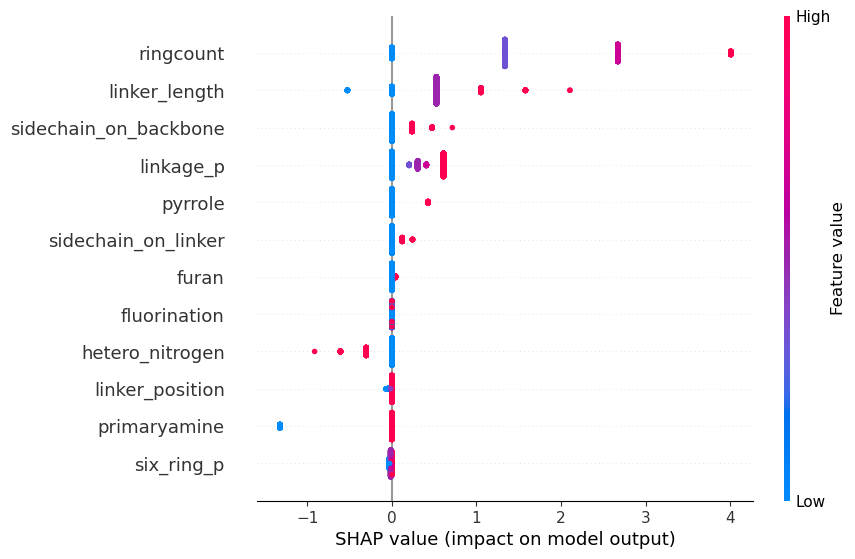

In [18]:
shap.plots.beeswarm(homo_shap_values,show=False,max_display=12,order=homo_shap_values.max(0))
#plt.savefig('../rawfigures/HOMO_shap_beeswarm.svg', dpi=1200)

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import shap


# Create dummy data range just for colorbar
cmap = sns.color_palette("RdBu", as_cmap=True)
cmap = shap.plots.colors.red_blue  # equivalent to "RdBu"

fig, ax = plt.subplots(figsize=(0.3, 3))  # adjust size and orientation
norm = plt.Normalize(vmin=0, vmax=1)
cb = plt.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap=cmap),
    cax=ax,
)

# Remove axes for a clean colormap strip
#ax.set_axis_off() # dont remove
cb.set_label("Value")  # optional label
plt.savefig("../rawfigures/colorbar_RdBu.tiff", dpi=900, bbox_inches='tight', pad_inches=0)
plt.close(fig)

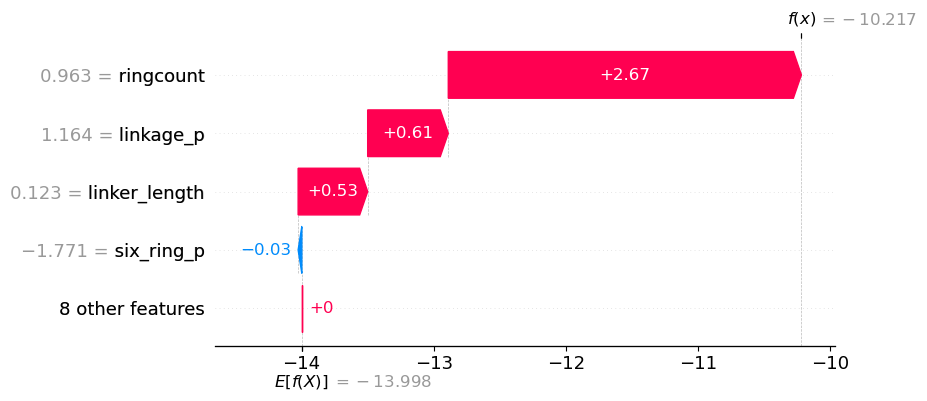

In [ ]:
shap.plots.waterfall(homo_shap_values[dataframe.reset_index().query('identifier == 101').index.values[0]],max_display=5)
#plt.savefig('../rawfigures/HOMO_shap_waterfall.svg', dpi=300)


In [ ]:
shap.plots.waterfall(homo_shap_values[dataframe.reset_index().query('identifier == 205').index.values[0]],max_display=5)
#plt.savefig('../rawfigures/HOMO_shap_waterfall.svg', dpi=300)

IndexError: index 0 is out of bounds for axis 0 with size 0

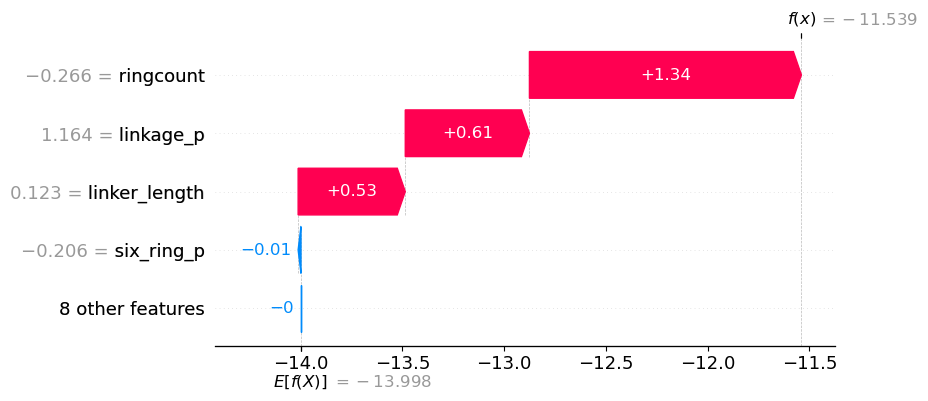

In [ ]:
shap.plots.waterfall(homo_shap_values[dataframe.reset_index().query('identifier == 204').index.values[0]],max_display=5)

**LUMO**

In [13]:
lumo_lasso_pipeline = best_models['LUMO']['Lasso']
lumo_shap_explainer = shap.Explainer(
    lumo_lasso_pipeline[1],
    lumo_lasso_pipeline[0].transform(X_train),
    feature_names=COLUMNS_DICT['machine_learning_features']
)

In [14]:
# get shap value and calibrate using generation 0 molecule
def get_lumo_shap_values(input_fingerprint_dataframe):
    input_fingerprint = input_fingerprint_dataframe[COLUMNS_DICT['machine_learning_features']].values
    lumo_shap_values = lumo_shap_explainer(lumo_lasso_pipeline[0].transform(input_fingerprint))

    base_index = input_fingerprint_dataframe.reset_index().query('identifier == 26').index.values[0]
    base_shap_value = lumo_shap_values.values[base_index - 1]
    lumo_shap_values.values = lumo_shap_values.values - base_shap_value
    prediction_base = lumo_lasso_pipeline.predict([input_fingerprint_dataframe.loc[26,COLUMNS_DICT['machine_learning_features']].to_list()])
    lumo_shap_values.base_values = np.repeat(prediction_base, len(lumo_shap_values.base_values))
    return lumo_shap_values

lumo_shap_values = get_lumo_shap_values(dataframe)

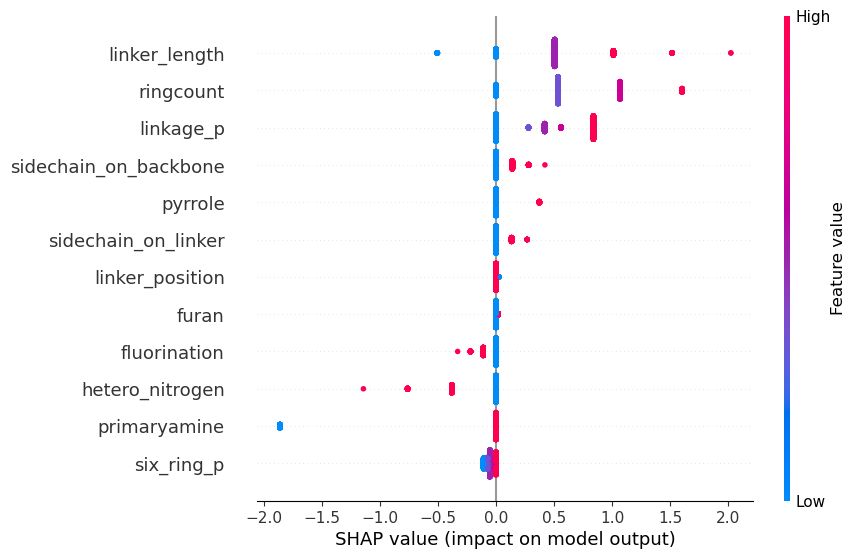

In [15]:
shap.plots.beeswarm(lumo_shap_values,show=False,max_display=12,order=lumo_shap_values.max(0))
plt.savefig('../rawfigures/LUMO_shap_beeswarm.svg', dpi=1200)

<Axes: xlabel='SHAP value (impact on model output)'>

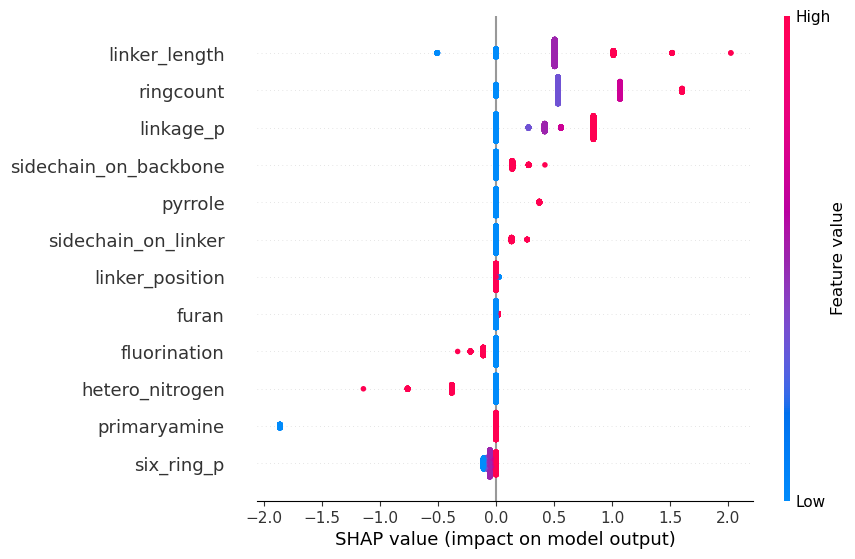

In [ ]:
shap.plots.beeswarm(lumo_shap_values,show=False,max_display=12,order=lumo_shap_values.max(0))
#plt.savefig('../rawfigures/LUMO_shap_beeswarm.svg', dpi=1200)

### MO and alignment type prediction

In [2]:
import csv
from utils import predict_mo_lasso, get_alignment_type_prediction

def generate_mo_prediction_csv_file_from_fingerprint(input_csv, output_csv):
    """
    Read the SMILES data, classify each SMILES based on HOMO_predicted, LUMO_predicted, and ringcount,
    and output the results to a new CSV file.
    
    Parameters:
    - input_csv: Path to the input CSV file containing SMILES, HOMO_predicted, LUMO_predicted, and ringcount.
    - output_csv: Path to the output CSV file where the classification results will be saved.
    """

    with open(input_csv, 'r') as infile, open(output_csv, 'w', newline='') as outfile:
        reader = csv.DictReader(infile)
        fieldnames = ['smiles_canonical','HOMO_prediction','LUMO_prediction','alignment_type_prediction']  # Add functional group names as columns
        writer = csv.DictWriter(outfile, fieldnames=fieldnames)
        writer.writeheader()

        for row in reader:
            smiles = row['smiles_canonical']
            fingerprint_dict = {key: float(row[key]) for key in COLUMNS_DICT['machine_learning_features']}
            HOMO_prediction = predict_mo_lasso(fingerprint_dict,target='HOMO')
            LUMO_prediction = predict_mo_lasso(fingerprint_dict,target='LUMO')

            ringcount = fingerprint_dict['ringcount']
            alignment_type_prediction = get_alignment_type_prediction(ringcount, HOMO_prediction, LUMO_prediction)
            output_row = {
                'smiles_canonical': smiles,
                'HOMO_prediction': HOMO_prediction,
                'LUMO_prediction': LUMO_prediction,
                'alignment_type_prediction': alignment_type_prediction
            }
            writer.writerow(output_row)


In [3]:
# obtain energy level alignment to each generation and save the results
for i in range(6,7):
    input_csv = PROJECT_ROOT_DIRECTORY + '01-rawdata/01-molecular-generation/fingerprints/fingerprints_generation_' + str(i) + '.csv'  # Input CSV with SMILES, HOMO_predicted, LUMO_predicted, and ringcount
    output_csv = PROJECT_ROOT_DIRECTORY + '01-rawdata/01-molecular-generation/mo-prediction/mo_prediction_generation_' + str(i) + '.csv'  # Output CSV to store the classified SMILES

    # Classify SMILES based on HOMO_predicted, LUMO_predicted, and ringcount
    generate_mo_prediction_csv_file_from_fingerprint(input_csv, output_csv)

### SHAP value for all generated molecules

In [15]:
organic_fingerprints_dataframe_path = PROJECT_ROOT_DIRECTORY+'02-metadata/06-csv-files/02-organic-fingerprints.csv'
organic_fingerprints_dataframe = pd.read_csv(organic_fingerprints_dataframe_path, index_col=0)

In [29]:
homo_shap_values_all = get_homo_shap_values(organic_fingerprints_dataframe)
lumo_shap_values_all = get_lumo_shap_values(organic_fingerprints_dataframe)

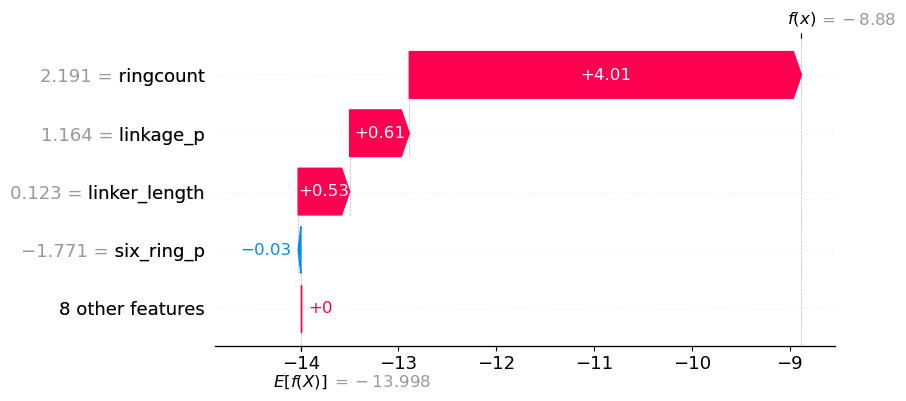

In [58]:
identifier = 102
shap.plots.waterfall(homo_shap_values_all[organic_fingerprints_dataframe.reset_index().query('identifier == '+str(identifier)).index.values[0]],max_display=5,show=False)
plt.savefig('../rawfigures/HOMO_shap_waterfall.svg', dpi=300)
plt.show()

In [57]:
plt.show()

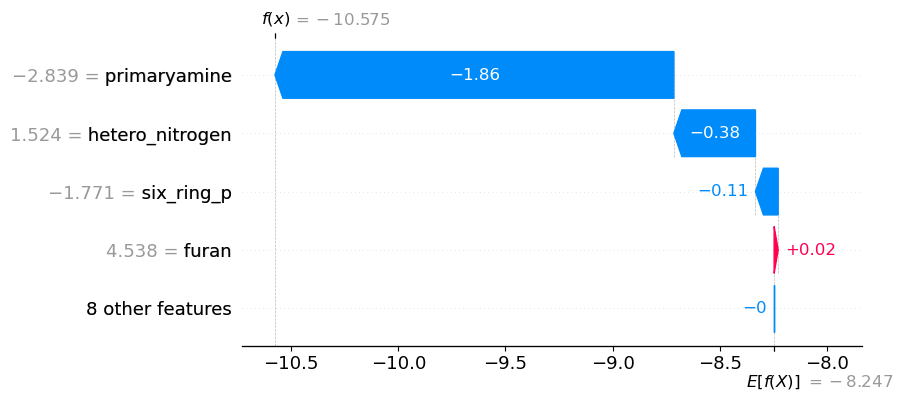

In [69]:
identifier = 3883
shap.plots.waterfall(lumo_shap_values_all[organic_fingerprints_dataframe.reset_index().query('identifier == '+str(identifier)).index.values[0]],max_display=5,show=False)
plt.savefig('../rawfigures/LUMO_shap_waterfall.svg', dpi=300)
plt.show()

In [67]:
plt.show()